### Preparing for work

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [125]:
import os
os.environ['ARCHIVE_NAME']="data.tar.gz"
os.environ["REPO_FOLDER"]="bel-tts/"

os.environ['DRIVE_ROOT']="/content/drive/MyDrive/"
os.environ["RUNTIME_ROOT"]="/content/sample_data/"

os.environ['DRIVE_DATA_ARCHIVE']=os.environ['DRIVE_ROOT'] + os.environ['ARCHIVE_NAME']
os.environ["RUNTIME_DATA_ARCHIVE"]=os.environ["RUNTIME_ROOT"] + os.environ["ARCHIVE_NAME"]

os.environ["RUNTIME_REPO"]=os.environ["RUNTIME_ROOT"] + os.environ["REPO_FOLDER"]

In [ ]:
os.chdir(os.environ["RUNTIME_ROOT"])
!gdown 1thgrwRJCpwq6qF9au_CkVcmBQJU7cH72
if not os.path.exists("be/"):
  os.makedirs("be/")
!tar -xzf $ARCHIVE_NAME -C "be"

In [ ]:
os.chdir(os.environ["RUNTIME_ROOT"])
!git clone -b main --single-branch https://github.com/jhlfrfufyfn/bel-tts.git

In [ ]:
%cd /content/sample_data/bel-tts

In [ ]:
# 4 minutes
# dependencies
!make system-deps
# install 🐸 TTS for development.
!make install

In [ ]:
!pip install --upgrade numpy

### Spectrogram analysis

In [131]:
%matplotlib inline

from TTS.utils.audio import AudioProcessor
from TTS.tts.utils.visual import plot_spectrogram
from TTS.config import load_config

import IPython.display as ipd
import glob

In [132]:
from librosa import display
from matplotlib import pylab as plt
import IPython

In [133]:
from TTS.config.shared_configs import BaseAudioConfig
CONFIG = BaseAudioConfig()

In [134]:
config_path = "/content/drive/MyDrive/config.json"
data_path = "/content/sample_data/be"
file_ext = ".wav"

In [135]:
file_paths = glob.glob(data_path + f"/**/*{file_ext}", recursive=True)

In [ ]:
# Change this to the index of the desired file listed below
sample_file_index = 1

SAMPLE_FILE_PATH = file_paths[sample_file_index]
SAMPLE_FILE_PATH

In [137]:
# including some comments on parameters
%%script false
   "audio":{
        // Audio processing parameters
        "num_mels": 80,         // size of the mel spec frame.
        "fft_size": 1024,       // number of stft frequency levels. Size of the linear spectogram frame.
        "sample_rate": 22050, //22050,   // DATASET-RELATED: wav sample-rate. If different than the original data, it is resampled.
        "win_length": 1024,     // stft window length in ms.
        "hop_length": 256,      // stft window hop-lengh in ms.
        "frame_length_ms": null,  // stft window length in ms.If null, 'win_length' is used.
        "frame_shift_ms": null,   // stft window hop-lengh in ms. If null, 'hop_length' is used.
        "preemphasis": 0.98,    // pre-emphasis to reduce spec noise and make it more structured. If 0.0, no -pre-emphasis.
        "min_level_db": -100,   // normalization range
        "ref_level_db": 20,     // reference level db, theoretically 20db is the sound of air.
        "power": 1.5,           // value to sharpen wav signals after GL algorithm.
        "griffin_lim_iters": 60,// #griffin-lim iterations. 30-60 is a good range. Larger the value, slower the generation.
        "stft_pad_mode": "reflect",
        // Normalization parameters
        "signal_norm": true,    // normalize the spec values in range [0, 1]
        "symmetric_norm": true, // move normalization to range [-1, 1]
        "max_norm": 4.0,          // scale normalization to range [-max_norm, max_norm] or [0, max_norm]
        "clip_norm": true,      // clip normalized values into the range.
        "mel_fmin": 0.0,         // minimum freq level for mel-spec. ~50 for male and ~95 for female voices. Tune for dataset!!
        "mel_fmax": 8000.0,        // maximum freq level for mel-spec. Tune for dataset!!
        "spec_gain": 20.0,
        "do_trim_silence": false,  // enable trimming of slience of audio as you load it. LJspeech (false), TWEB (false), Nancy (true)
        "trim_db": 60          // threshold for timming silence. Set this according to your dataset.
    },


In [413]:
tuned_params = {
        "fft_size": 1024,
        "win_length": 1024,
        "hop_length": 256,
        "frame_shift_ms": None,
        "frame_length_ms": None,
        "stft_pad_mode": "reflect",
        "sample_rate": 16000,
        "resample": True,
        "preemphasis": 0.0,
        "ref_level_db": 20,
        "do_sound_norm": True,
        "log_func": "np.log10",
        "do_trim_silence": True,
        "trim_db": 45,
        "do_rms_norm": False,
        "db_level": None,
        "power": 1.5,
        "griffin_lim_iters": 60,
        "num_mels": 80,
        "mel_fmin": 50,
        "mel_fmax": 8000,
        "spec_gain": 20,
        "do_amp_to_db_linear": True,
        "do_amp_to_db_mel": True,
        "pitch_fmax": 640.0,
        "pitch_fmin": 0.0,
        "signal_norm": True,
        "min_level_db": -100,
        "symmetric_norm": True,
        "max_norm": 4.0,
        "clip_norm": True,
        "stats_path": None
}

In [414]:
%%script false
# (not used i guess)
# These options have to be forced off in order to avoid errors about the 
# pre-calculated not matching the options being tuned.
reset={
 'signal_norm': True,  # check this if you want to test normalization parameters.
 'stats_path': None,
 'symmetric_norm': False,
 'max_norm': 1,
 'clip_norm': True,
}

In [415]:
tuned_config = CONFIG.copy()
#tuned_config.update(reset)
tuned_config.update(tuned_params)

In [ ]:
AP = AudioProcessor(**tuned_config);

In [417]:
wav = AP.load_wav(SAMPLE_FILE_PATH)
plt.rcParams['figure.figsize'] = (20.0, 16.0)
ipd.Audio(data=wav, rate=AP.sample_rate) 

Max: 2.9996881
Min: -4.0
Mean: -1.2188817


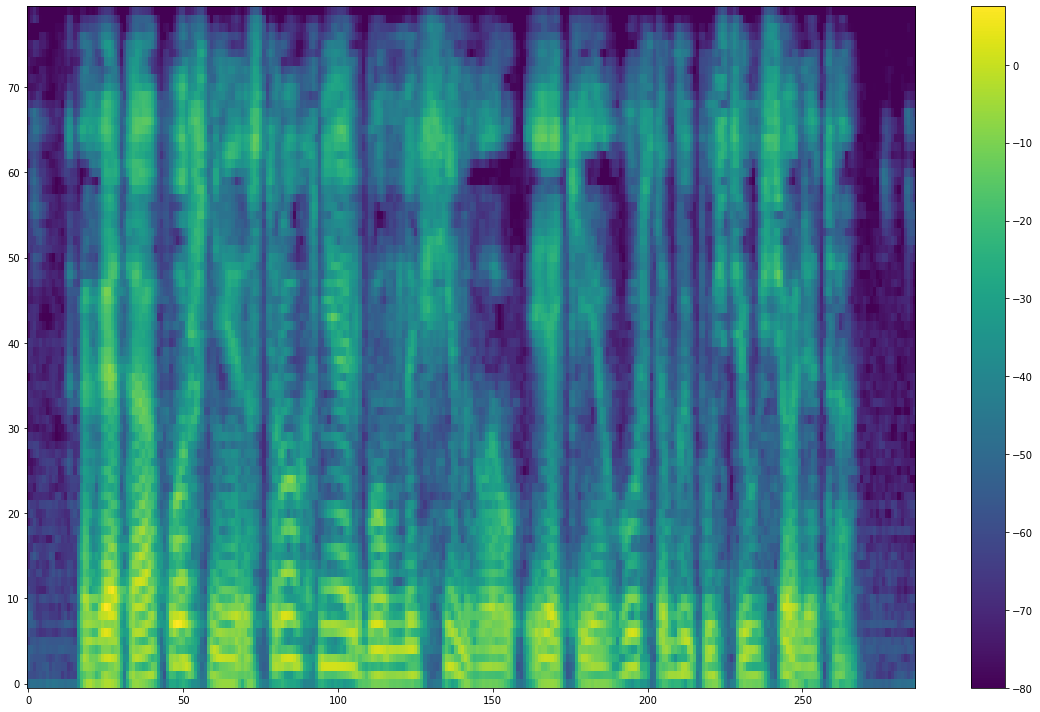

In [418]:
mel = AP.melspectrogram(wav)
plt.rcParams['figure.figsize'] = (20.0, 16.0)
print("Max:", mel.max())
print("Min:", mel.min())
print("Mean:", mel.mean())
plot_spectrogram(mel.T, AP, output_fig=True)

wav_gen = AP.inv_melspectrogram(mel)
ipd.Audio(wav_gen, rate=AP.sample_rate)

Max: 4.0
Min: -4.0
Mean: 0.069368236


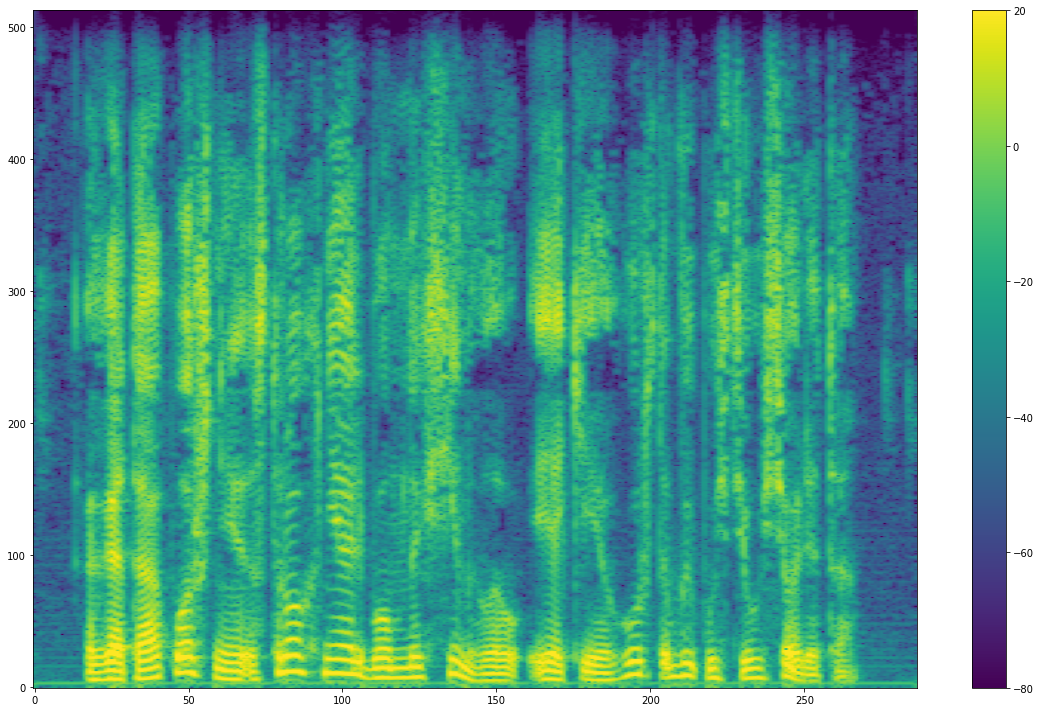

In [419]:
spec = AP.spectrogram(wav)
print("Max:", spec.max())
print("Min:", spec.min())
print("Mean:", spec.mean())
plot_spectrogram(spec.T, AP, output_fig=True)

wav_gen = AP.inv_spectrogram(spec)
ipd.Audio(wav_gen, rate=AP.sample_rate)

In [420]:

plt.rcParams['figure.figsize'] = (20.0, 16.0)

def compare_values(attribute, values):
    """
    attributes (str): the names of the attribute you like to test.
    values (list): list of values to compare.
    """
    file = SAMPLE_FILE_PATH
    wavs = []
    for idx, val in enumerate(values):
        set_val_cmd = "AP.{}={}".format(attribute, val)
        exec(set_val_cmd)
        wav = AP.load_wav(file)
        spec = AP.spectrogram(wav)
        spec_norm = AP.denormalize(spec.T)
        plt.subplot(len(values), 2, 2*idx + 1)
        plt.imshow(spec_norm.T, aspect="auto", origin="lower")
        #         plt.colorbar()
        plt.tight_layout()
        wav_gen = AP.inv_spectrogram(spec)
        wavs.append(wav_gen)
        plt.subplot(len(values), 2, 2*idx + 2)
        display.waveplot(wav, alpha=0.5)
        display.waveplot(wav_gen, alpha=0.25)
        plt.title("{}={}".format(attribute, val))
        plt.tight_layout()
    
    wav = AP.load_wav(file)
    print(" > Ground-truth")
    IPython.display.display(IPython.display.Audio(wav, rate=AP.sample_rate))
    
    for idx, wav_gen in enumerate(wavs):
        val = values[idx]
        print(" > {} = {}".format(attribute, val))
        IPython.display.display(IPython.display.Audio(wav_gen, rate=AP.sample_rate))


 > Ground-truth


 > mel_fmax = None


 > mel_fmax = 5000


 > mel_fmax = 6000


 > mel_fmax = 7000


 > mel_fmax = 8000


 > mel_fmax = 9000


 > mel_fmax = 10000


 > mel_fmax = 15000


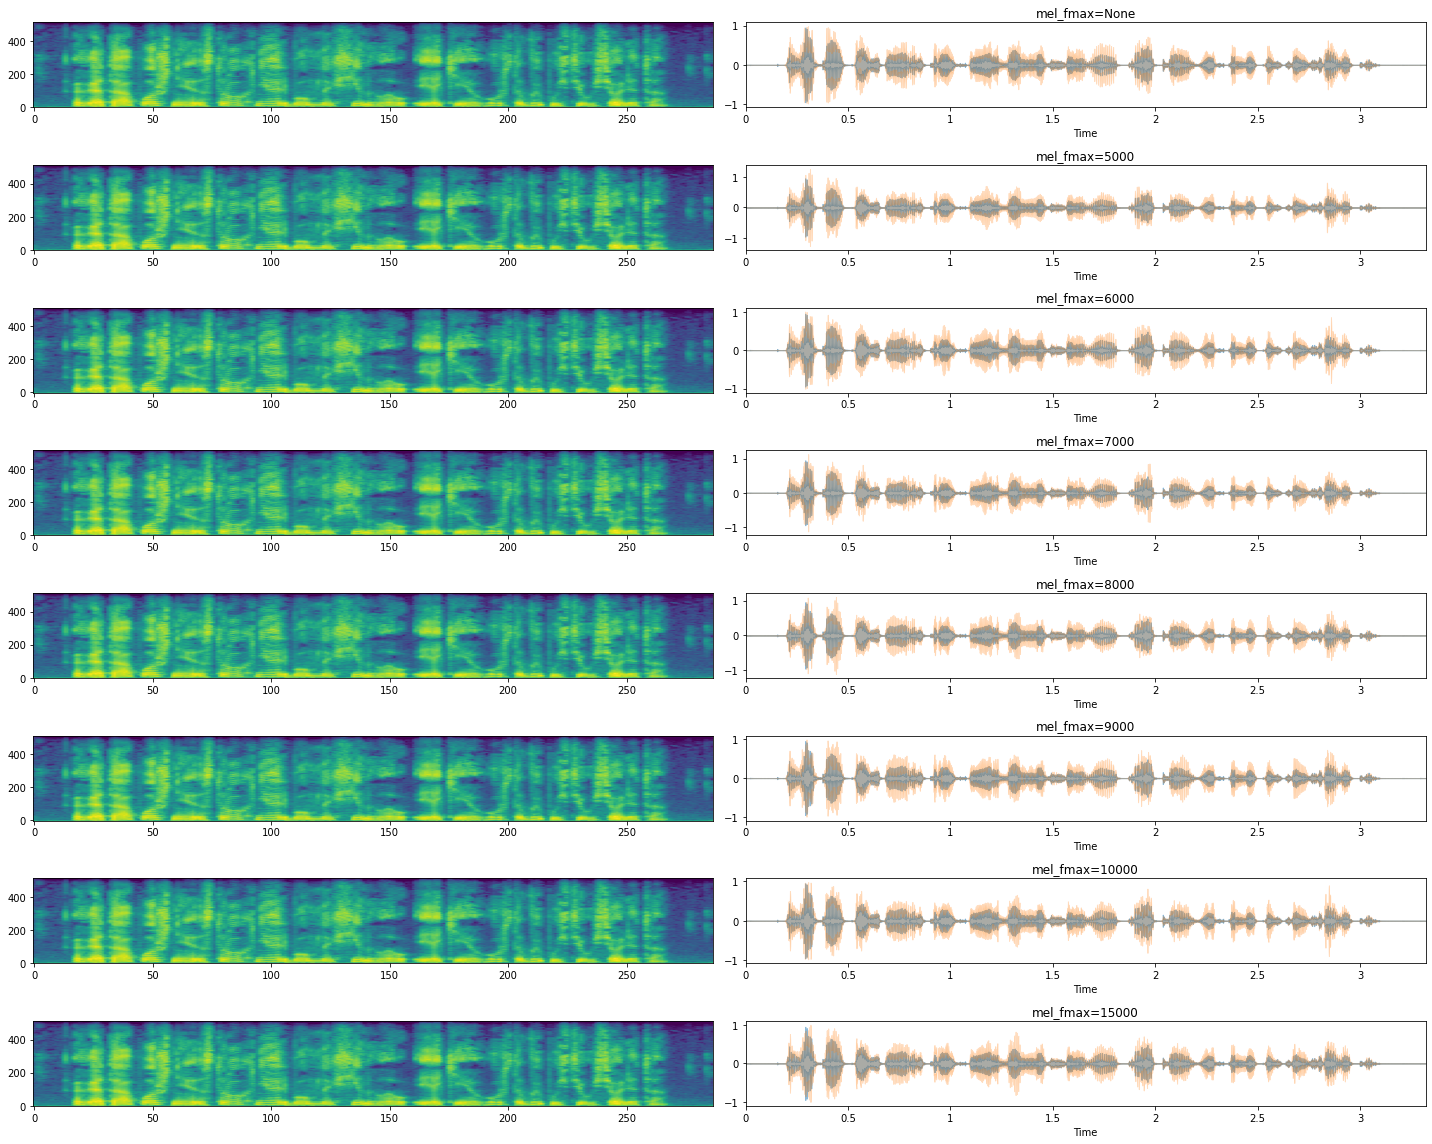

In [421]:
compare_values('mel_fmax', [None, 5000, 6000, 7000, 8000, 9000, 10000, 15000])

 > Ground-truth


 > preemphasis = 0


 > preemphasis = 0.5


 > preemphasis = 0.97


 > preemphasis = 0.98


 > preemphasis = 0.99


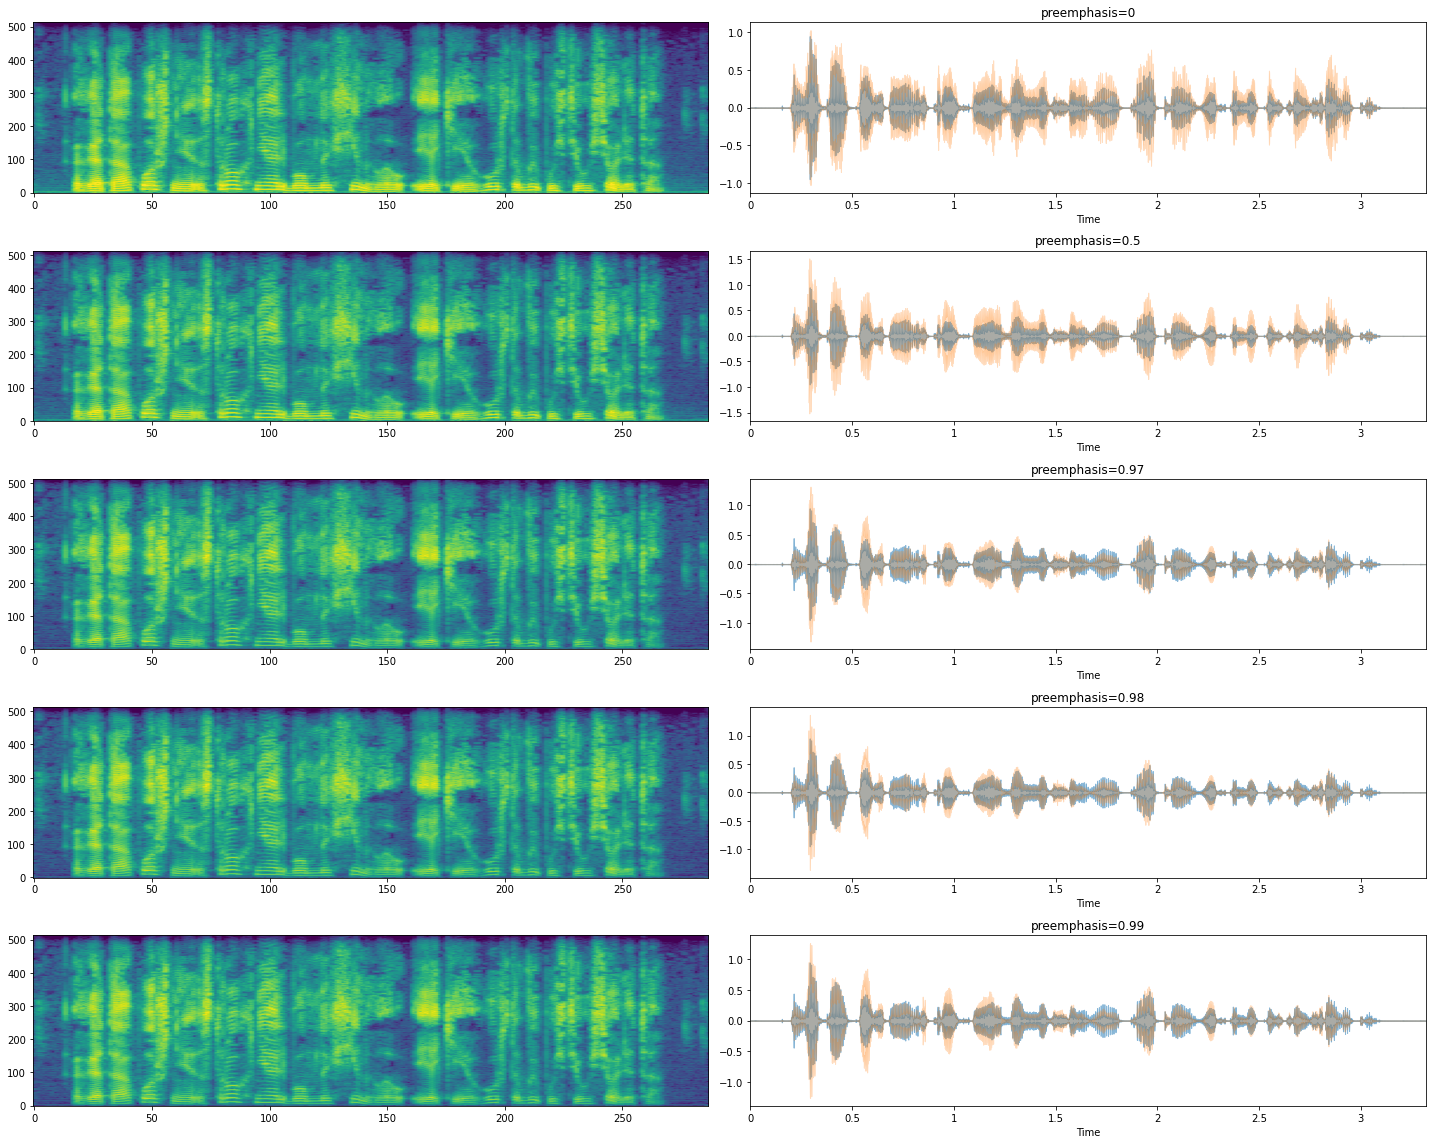

In [422]:
compare_values("preemphasis", [0, 0.5, 0.97, 0.98, 0.99])


In [423]:
#compare_values("ref_level_db", [2, 5, 10, 15, 20, 25, 30, 35, 40, 1000])
